In [827]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing

# Arguments

In [828]:
args = {'noise':0.01,
        'percent training data':0.7,
        'spec scale':10**12,
        'correlation':0,

        'forward learning rate':0.01,
        'inverse learning rate':0.01,

        'forward training epochs':1000,
        'inverse training epochs':1000,

        'forward training criterion':nn.L1Loss(),
        'inverse training criterion':nn.L1Loss(),
        'testing criterion':nn.L1Loss(),
        
        'optimizer':torch.optim.Rprop
        }

now = datetime.now()

# Data Prep

In [829]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [830]:
df = pd.read_excel('wide_range.xlsx')

spec = df.iloc[:,11:] 
temp = df.iloc[:,:11]

In [831]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,3.105584e-14,2.999482e-14,4.442183e-14,3.656011e-14,5.194757e-14,4.973315e-14,7.323828e-14,5.203014e-14,7.218750e-14,8.672268e-14,...,2.291410e-12,2.333930e-12,2.371461e-12,2.402093e-12,2.424702e-12,2.433566e-12,2.417632e-12,2.365972e-12,2.285583e-12,2.211520e-12
1,2.303472e-14,2.137935e-14,3.026088e-14,2.454882e-14,3.471853e-14,3.357273e-14,5.103051e-14,3.893226e-14,5.676652e-14,7.142763e-14,...,1.639899e-12,1.669825e-12,1.698490e-12,1.723560e-12,1.743375e-12,1.753393e-12,1.745497e-12,1.711668e-12,1.656824e-12,1.606307e-12
2,3.321009e-14,2.824623e-14,3.587004e-14,2.765798e-14,3.802290e-14,3.688717e-14,5.919539e-14,5.122215e-14,8.020764e-14,1.073738e-13,...,4.487510e-12,4.550427e-12,4.603621e-12,4.643395e-12,4.667637e-12,4.665521e-12,4.616247e-12,4.499595e-12,4.329608e-12,4.173042e-12
3,1.357453e-14,1.187304e-14,1.558260e-14,1.228372e-14,1.717658e-14,1.683286e-14,2.695498e-14,2.296024e-14,3.580425e-14,4.786284e-14,...,2.760638e-12,2.807683e-12,2.849087e-12,2.882405e-12,2.906159e-12,2.913462e-12,2.891133e-12,2.826217e-12,2.727201e-12,2.635977e-12
4,2.619885e-14,2.332198e-14,3.140154e-14,2.493494e-14,3.488262e-14,3.382589e-14,5.274100e-14,4.275298e-14,6.464003e-14,8.408254e-14,...,3.121194e-12,3.173340e-12,3.218273e-12,3.253581e-12,3.277914e-12,3.283670e-12,3.256076e-12,3.180625e-12,3.066965e-12,2.962253e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,3.291908e-14,2.904236e-14,3.868747e-14,3.052280e-14,4.249031e-14,4.114082e-14,6.427529e-14,5.247101e-14,7.966764e-14,1.038464e-13,...,3.492639e-12,3.541544e-12,3.586094e-12,3.622037e-12,3.646522e-12,3.650482e-12,3.617422e-12,3.531303e-12,3.402929e-12,3.284666e-12
2196,2.234104e-14,1.882600e-14,2.361172e-14,1.812234e-14,2.488261e-14,2.422053e-14,3.928364e-14,3.469407e-14,5.502010e-14,7.455935e-14,...,4.885042e-12,4.950908e-12,5.006120e-12,5.046707e-12,5.070411e-12,5.065506e-12,5.009465e-12,4.880432e-12,4.693737e-12,4.521797e-12
2197,2.847468e-14,2.408754e-14,3.030068e-14,2.326424e-14,3.189002e-14,3.105177e-14,5.022622e-14,4.412174e-14,6.973943e-14,9.391391e-14,...,2.505269e-12,2.542833e-12,2.578975e-12,2.609906e-12,2.632938e-12,2.641187e-12,2.622551e-12,2.565215e-12,2.476821e-12,2.395382e-12
2198,1.648649e-14,1.406005e-14,1.783686e-14,1.379136e-14,1.903271e-14,1.863127e-14,3.027923e-14,2.667106e-14,4.232606e-14,5.720658e-14,...,1.138944e-12,1.158522e-12,1.179434e-12,1.199129e-12,1.215649e-12,1.225428e-12,1.222663e-12,1.201639e-12,1.165695e-12,1.132607e-12


In [832]:
# scale spectrum data by 10^12
spec = spec.apply(lambda x: x*args['spec scale'])

In [833]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.029995,0.044422,0.036560,0.051948,0.049733,0.073238,0.052030,0.072187,0.086723,...,2.291410,2.333930,2.371461,2.402093,2.424702,2.433566,2.417632,2.365972,2.285583,2.211520
1,0.023035,0.021379,0.030261,0.024549,0.034719,0.033573,0.051031,0.038932,0.056767,0.071428,...,1.639899,1.669825,1.698490,1.723560,1.743375,1.753393,1.745497,1.711668,1.656824,1.606307
2,0.033210,0.028246,0.035870,0.027658,0.038023,0.036887,0.059195,0.051222,0.080208,0.107374,...,4.487510,4.550427,4.603621,4.643395,4.667637,4.665521,4.616247,4.499595,4.329608,4.173042
3,0.013575,0.011873,0.015583,0.012284,0.017177,0.016833,0.026955,0.022960,0.035804,0.047863,...,2.760638,2.807683,2.849087,2.882405,2.906159,2.913462,2.891133,2.826217,2.727201,2.635977
4,0.026199,0.023322,0.031402,0.024935,0.034883,0.033826,0.052741,0.042753,0.064640,0.084083,...,3.121194,3.173340,3.218273,3.253581,3.277914,3.283670,3.256076,3.180625,3.066965,2.962253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.032919,0.029042,0.038687,0.030523,0.042490,0.041141,0.064275,0.052471,0.079668,0.103846,...,3.492639,3.541544,3.586094,3.622037,3.646522,3.650482,3.617422,3.531303,3.402929,3.284666
2196,0.022341,0.018826,0.023612,0.018122,0.024883,0.024221,0.039284,0.034694,0.055020,0.074559,...,4.885042,4.950908,5.006120,5.046707,5.070411,5.065506,5.009465,4.880432,4.693737,4.521797
2197,0.028475,0.024088,0.030301,0.023264,0.031890,0.031052,0.050226,0.044122,0.069739,0.093914,...,2.505269,2.542833,2.578975,2.609906,2.632938,2.641187,2.622551,2.565215,2.476821,2.395382
2198,0.016486,0.014060,0.017837,0.013791,0.019033,0.018631,0.030279,0.026671,0.042326,0.057207,...,1.138944,1.158522,1.179434,1.199129,1.215649,1.225428,1.222663,1.201639,1.165695,1.132607


In [834]:
# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=spec.shape)
spec_noisy = spec + noise

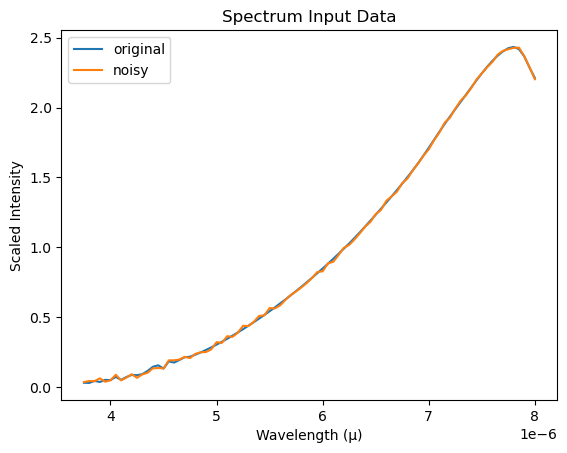

In [835]:
plt.title('Spectrum Input Data')
plt.plot(spec.iloc[0], label='original')
plt.plot(spec_noisy.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

In [836]:
# Normalize clean and noisy spectrum data
scaler = preprocessing.StandardScaler()

scaler.fit(spec)
spec_scaled = scaler.transform(spec)
spec_unscaled = scaler.inverse_transform(spec_scaled)

scaler.fit(spec_noisy)
spec_noisy_scaled = scaler.transform(spec_noisy)

spec_scaled_df = pd.DataFrame(spec_scaled, columns=spec.columns)
spec_noisy_scaled_df = pd.DataFrame(spec_noisy_scaled, columns = spec.columns)


/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


In [837]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.029995,0.044422,0.036560,0.051948,0.049733,0.073238,0.052030,0.072187,0.086723,...,2.291410,2.333930,2.371461,2.402093,2.424702,2.433566,2.417632,2.365972,2.285583,2.211520
1,0.023035,0.021379,0.030261,0.024549,0.034719,0.033573,0.051031,0.038932,0.056767,0.071428,...,1.639899,1.669825,1.698490,1.723560,1.743375,1.753393,1.745497,1.711668,1.656824,1.606307
2,0.033210,0.028246,0.035870,0.027658,0.038023,0.036887,0.059195,0.051222,0.080208,0.107374,...,4.487510,4.550427,4.603621,4.643395,4.667637,4.665521,4.616247,4.499595,4.329608,4.173042
3,0.013575,0.011873,0.015583,0.012284,0.017177,0.016833,0.026955,0.022960,0.035804,0.047863,...,2.760638,2.807683,2.849087,2.882405,2.906159,2.913462,2.891133,2.826217,2.727201,2.635977
4,0.026199,0.023322,0.031402,0.024935,0.034883,0.033826,0.052741,0.042753,0.064640,0.084083,...,3.121194,3.173340,3.218273,3.253581,3.277914,3.283670,3.256076,3.180625,3.066965,2.962253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.032919,0.029042,0.038687,0.030523,0.042490,0.041141,0.064275,0.052471,0.079668,0.103846,...,3.492639,3.541544,3.586094,3.622037,3.646522,3.650482,3.617422,3.531303,3.402929,3.284666
2196,0.022341,0.018826,0.023612,0.018122,0.024883,0.024221,0.039284,0.034694,0.055020,0.074559,...,4.885042,4.950908,5.006120,5.046707,5.070411,5.065506,5.009465,4.880432,4.693737,4.521797
2197,0.028475,0.024088,0.030301,0.023264,0.031890,0.031052,0.050226,0.044122,0.069739,0.093914,...,2.505269,2.542833,2.578975,2.609906,2.632938,2.641187,2.622551,2.565215,2.476821,2.395382
2198,0.016486,0.014060,0.017837,0.013791,0.019033,0.018631,0.030279,0.026671,0.042326,0.057207,...,1.138944,1.158522,1.179434,1.199129,1.215649,1.225428,1.222663,1.201639,1.165695,1.132607


In [838]:
spec_unscaled

array([[0.03105584, 0.02999482, 0.04442183, ..., 2.36597201, 2.28558255,
        2.21152006],
       [0.02303472, 0.02137935, 0.03026088, ..., 1.71166774, 1.65682389,
        1.60630741],
       [0.03321009, 0.02824623, 0.03587004, ..., 4.49959521, 4.32960797,
        4.17304151],
       ...,
       [0.02847468, 0.02408754, 0.03030068, ..., 2.56521541, 2.47682096,
        2.39538243],
       [0.01648649, 0.01406005, 0.01783686, ..., 1.20163893, 1.16569548,
        1.13260748],
       [0.02009135, 0.01711356, 0.02174333, ..., 4.45698039, 4.28885161,
        4.13399539]])

In [839]:
spec_noisy_scaled_df    

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.719092,1.524968,0.650338,2.583335,0.223627,0.891159,1.523445,0.378521,0.208916,0.389338,...,-0.314526,-0.313723,-0.299914,-0.301213,-0.307544,-0.305886,-0.291520,-0.297054,-0.295726,-0.303468
1,0.604348,-0.744330,-0.820331,-0.883993,0.059912,0.501635,-0.189056,-0.308878,-0.142995,-0.949405,...,-0.795780,-0.793454,-0.787358,-0.803043,-0.789603,-0.784398,-0.787813,-0.800899,-0.791105,-0.789270
2,0.187904,2.108507,0.286666,-0.041048,-0.569930,0.218801,0.787764,-0.306204,-0.033052,0.682739,...,1.292226,1.313418,1.314819,1.309063,1.316430,1.311774,1.306313,1.310646,1.312402,1.324209
3,-1.649200,-0.139461,-1.532686,-0.746469,-0.986008,-1.054169,-0.519638,-0.984944,-1.202164,-1.922221,...,0.035466,0.033383,0.040447,0.043873,0.052336,0.026431,0.041872,0.035988,0.046367,0.043359
4,0.476125,-0.213878,0.880261,0.897011,-0.613967,0.053891,0.314946,-0.172434,-0.516972,0.287539,...,0.306940,0.293856,0.301994,0.314702,0.304825,0.316037,0.319643,0.304996,0.314272,0.313545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-0.074289,0.466127,0.083907,0.294573,1.346847,0.856087,0.677129,1.001059,0.917497,0.721130,...,0.575318,0.568973,0.584593,0.573491,0.583408,0.593479,0.576667,0.582016,0.572290,0.583592
2196,0.039090,-0.531115,-1.909645,-0.504820,-0.371335,-1.062257,-0.643908,-0.398337,-1.155873,-0.110286,...,1.617107,1.605812,1.602167,1.604837,1.617420,1.604502,1.583243,1.591563,1.599817,1.588153
2197,-0.043921,-0.942150,0.704339,0.067083,0.154420,0.455858,0.484702,0.190240,-0.150383,0.160147,...,-0.151331,-0.158911,-0.157439,-0.163253,-0.151975,-0.154555,-0.149558,-0.148186,-0.147639,-0.144994
2198,-1.124461,0.066893,-0.833385,-0.910268,-0.794229,-1.243191,-0.265038,-0.504153,-1.538957,-1.007557,...,-1.172373,-1.163723,-1.165354,-1.169659,-1.177032,-1.179193,-1.176279,-1.178050,-1.169966,-1.176997


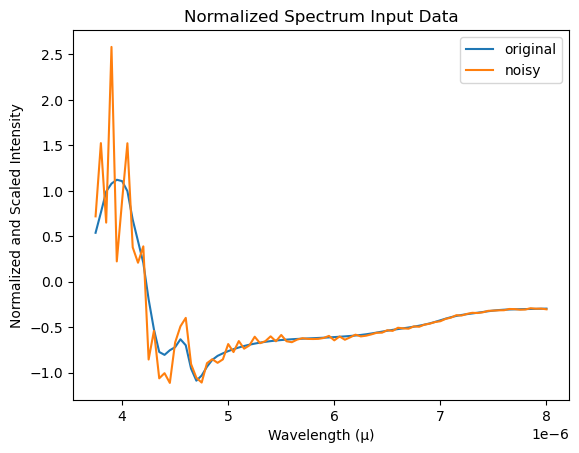

In [840]:
plt.title('Normalized Spectrum Input Data')
plt.plot(spec_scaled_df.iloc[0], label='original')
plt.plot(spec_noisy_scaled_df.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Normalized and Scaled Intensity")
plt.legend()
plt.show()

In [841]:
spec_train_df, spec_test_df, temp_train_df, temp_test_df = train_test_split(spec_noisy_scaled_df, temp, train_size=args['percent training data'], random_state=101)

spec_train = df_to_tensor(spec_train_df)
spec_test = df_to_tensor(spec_test_df)
temp_train = df_to_tensor(temp_train_df)
temp_test = df_to_tensor(temp_test_df)

In [842]:
# Feature Selection

In [843]:
spec_train

tensor([[ 1.4162,  0.2115,  1.8971,  ...,  0.7049,  0.7085,  0.6827],
        [-0.0822,  1.9712,  0.8669,  ..., -0.2740, -0.2790, -0.2758],
        [ 0.2192, -1.3938, -0.5304,  ..., -0.6796, -0.6750, -0.6667],
        ...,
        [ 0.9664,  2.7842,  2.1299,  ...,  1.9155,  1.9306,  1.9214],
        [-1.0498, -0.9624, -0.3930,  ..., -0.0926, -0.1022, -0.0864],
        [-0.3687, -0.2069, -0.7705,  ...,  0.5151,  0.5204,  0.5191]])

In [844]:
temp_train

tensor([[370.3413, 328.5613, 326.2462,  ..., 334.0032, 331.4733, 344.6604],
        [358.7178, 321.1420, 335.1217,  ..., 336.1974, 344.1709, 318.3873],
        [303.5786, 296.0121, 320.1395,  ..., 300.9098, 290.0527, 305.2413],
        ...,
        [370.2241, 340.5473, 330.7923,  ..., 343.7119, 361.5406, 369.9658],
        [308.7229, 320.0291, 305.8729,  ..., 333.4956, 311.0175, 324.1667],
        [338.4227, 306.0559, 297.0075,  ..., 323.1169, 302.0772, 340.2445]])

# Model Design

In [845]:
class ForwardNet(nn.Module):
    def __init__(self, middle_size, io_size):
        super(ForwardNet, self).__init__()
        self.lin1 = nn.Linear(middle_size, 60)
        self.lin2 = nn.Linear(60, 45)
        self.lin3 = nn.Linear(45, 30)
        self.lin4 = nn.Linear(30, 30)
        self.lin5 = nn.Linear(30, 30)
        self.lin_fin = nn.Linear(30, io_size)


    def forward(self, temp):
        x = F.leaky_relu(self.lin1(temp))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_spec = self.lin_fin(x)
        return pred_spec

In [846]:
class InverseNet(nn.Module):
    def __init__(self, io_size, middle_size):
        super(InverseNet, self).__init__()
        self.lin1 = nn.Linear(io_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin4 = nn.Linear(60, 60)
        self.lin5 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, middle_size)

    def forward(self, spec):
        x = F.leaky_relu(self.lin1(spec))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_temp = self.lin_fin(x)
        return pred_temp

In [847]:
class TandemNet(nn.Module):
    def __init__(self, forward_model, inverse_model):
        super(TandemNet, self).__init__()
        self.forward_model = forward_model
        self.inverse_model = inverse_model

    def forward(self, spec_train):
        pred_temp = self.inverse_model(spec_train)
        pred_spec = self.forward_model(pred_temp)
        return pred_temp, pred_spec

In [848]:
_, middle_size = temp.shape
_, io_size = spec_noisy_scaled_df.shape

# define variables for each model
forward_model = ForwardNet(middle_size, io_size)
inverse_model = InverseNet(io_size, middle_size)
tandem_net = TandemNet(forward_model, inverse_model)


x = torch.rand(1540, io_size)
print(forward_model(inverse_model(x)).shape)
pred_temp_x, pred_spec_x = tandem_net(x)
print(pred_spec_x.shape)

torch.Size([1540, 86])
torch.Size([1540, 86])


# Training Loop

In [849]:
def train_forward_model(forward_model, temp_train):
    print('FORWARD MODEL TRAINING')

    forward_loss_list = []
    forward_loss_sum = 0

    num_forward_epochs = args['forward training epochs']
    criterion = args['forward training criterion']
    optimizer = args['optimizer'](forward_model.parameters(), lr=args['forward learning rate'])

    for epoch in range(num_forward_epochs):
        # forward pass and loss
        pred_spec = forward_model(temp_train)
        loss = criterion(spec_train, pred_spec)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            forward_loss_sum += loss.item()

        forward_loss_list.append(loss.item())

        if (epoch + 1) % (num_forward_epochs / 10) == 0:
            print(f'forward epoch: {epoch + 1}, forward loss = {loss}')

    avg_forward_loss = forward_loss_sum / (num_forward_epochs - 100)
    print(f'\nAVERAGE FORWARD LOSS: {avg_forward_loss}')

    return forward_loss_list
        

In [850]:
def train_inverse_model(tandem_net, spec_train):
    print('\nINVERSE MODEL TRAINING')

    # Fix the parameters of the forward model
    for param in forward_model.parameters():
        param.requires_grad = False

    tandem_loss_list = []
    inverse_loss_list = []
    
    tandem_loss_sum = 0

    num_inverse_epochs = args['inverse training epochs']
    criterion = args['inverse training criterion']
    optimizer = args['optimizer'](tandem_net.parameters(), lr=args['inverse learning rate'])

    for epoch in range(num_inverse_epochs):
        # pass through tandem model and calculate loss
        pred_temp, pred_spec = tandem_net(spec_train)
        loss = criterion(spec_train, pred_spec)

        # calculate inverse loss (too see spec to temp accuracy)
        inverse_loss = criterion(temp_train, pred_temp)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        inverse_loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            tandem_loss_sum += loss.item()

        tandem_loss_list.append(loss.item())
        inverse_loss_list.append(inverse_loss.item())

        if (epoch + 1) % (num_inverse_epochs / 10) == 0:
            print(f'forward epoch: {epoch + 1}, tandem loss = {loss}, inverse loss = {inverse_loss}')

    avg_inverse_loss = tandem_loss_sum / (num_inverse_epochs - 100)
    print(f'\nAVERAGE INVERSE LOSS: {avg_inverse_loss}')
    
    return tandem_loss_list, inverse_loss_list

In [851]:
forward_loss_list = train_forward_model(forward_model, temp_train)
tandem_loss_list, inverse_loss_list = train_inverse_model(tandem_net, spec_train)

FORWARD MODEL TRAINING


forward epoch: 100, forward loss = 0.39978569746017456
forward epoch: 200, forward loss = 0.3462677001953125
forward epoch: 300, forward loss = 0.2845748960971832
forward epoch: 400, forward loss = 0.20816127955913544
forward epoch: 500, forward loss = 0.17863218486309052
forward epoch: 600, forward loss = 0.16816125810146332
forward epoch: 700, forward loss = 0.1623203009366989
forward epoch: 800, forward loss = 0.15818442404270172
forward epoch: 900, forward loss = 0.15469209849834442
forward epoch: 1000, forward loss = 0.15088173747062683

AVERAGE FORWARD LOSS: 0.21392386994428106

INVERSE MODEL TRAINING
forward epoch: 100, tandem loss = 0.7535679936408997, inverse loss = 11.484224319458008
forward epoch: 200, tandem loss = 0.1980324685573578, inverse loss = 7.163485050201416
forward epoch: 300, tandem loss = 0.16147617995738983, inverse loss = 5.9253315925598145
forward epoch: 400, tandem loss = 0.14647598564624786, inverse loss = 5.489171981811523
forward epoch: 500, tandem loss =

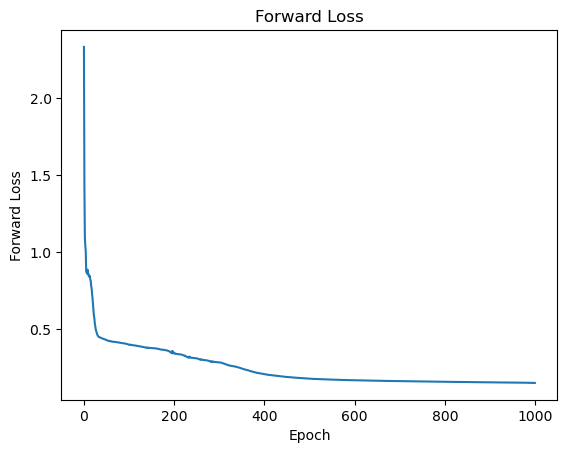

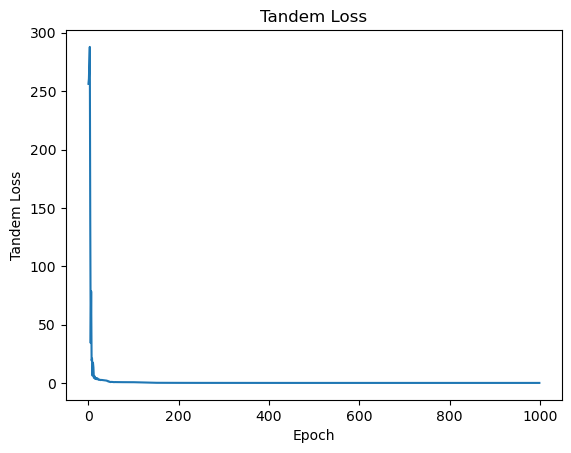

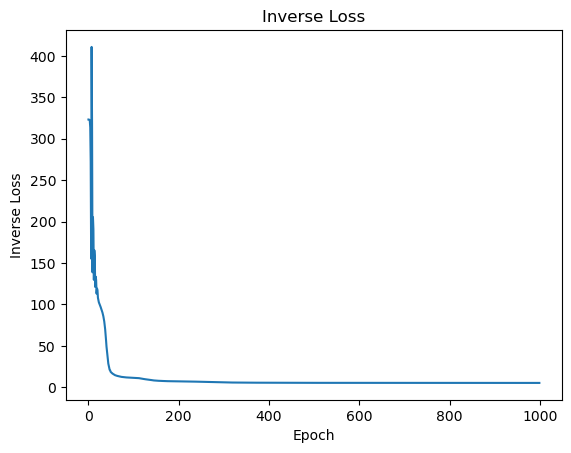

In [852]:
# plot forward loss
plt.plot(forward_loss_list)

plt.title("Forward Loss")
plt.xlabel("Epoch")
plt.ylabel("Forward Loss")
plt.show()


# plot tandem loss
plt.plot(tandem_loss_list)

plt.title("Tandem Loss")
plt.xlabel("Epoch")
plt.ylabel("Tandem Loss")
plt.show()

# plot inverse loss
plt.plot(inverse_loss_list)

plt.title("Inverse Loss")
plt.xlabel("Epoch")
plt.ylabel("Inverse Loss")
plt.show()

# Testing

In [853]:
pred_temp, pred_spec = tandem_net(spec_test)

In [854]:
# pred_temp = scaler.inverse_transform(pred_temp.detach().numpy())

In [855]:
pred_temp

tensor([[298.4615, 313.6591, 318.0440,  ..., 323.4407, 321.3902, 293.1238],
        [362.3265, 342.2469, 337.1926,  ..., 318.5487, 307.3913, 273.8188],
        [289.6204, 300.6732, 305.9713,  ..., 327.0179, 332.6591, 339.0729],
        ...,
        [309.6924, 314.4812, 314.7989,  ..., 315.6656, 314.1754, 293.9240],
        [281.1928, 298.7104, 307.7449,  ..., 333.3283, 338.7453, 340.5365],
        [348.8667, 332.2671, 326.6010,  ..., 324.4142, 325.8583, 304.6520]],
       grad_fn=<AddmmBackward0>)

In [856]:
pred_spec = scaler.inverse_transform(pred_spec.detach().numpy())

In [857]:
pred_spec

array([[0.01842161, 0.0151423 , 0.01949611, ..., 1.419084  , 1.3712882 ,
        1.3301255 ],
       [0.03805527, 0.03431668, 0.04761939, ..., 0.9305971 , 0.9491186 ,
        0.92891216],
       [0.01671889, 0.01309366, 0.01674667, ..., 3.4935136 , 3.3805366 ,
        3.268969  ],
       ...,
       [0.01662004, 0.01381164, 0.01929504, ..., 1.4286106 , 1.3854581 ,
        1.346579  ],
       [0.01780933, 0.01387229, 0.01653524, ..., 3.5416853 , 3.4254167 ,
        3.3109698 ],
       [0.0298852 , 0.02668802, 0.03754225, ..., 1.8635172 , 1.8041526 ,
        1.7407917 ]], dtype=float32)

In [858]:
spec_test = scaler.inverse_transform(spec_test.detach().numpy())

In [859]:
spec_test

array([[1.5919618e-02, 1.1941826e-02, 1.8556137e-02, ..., 1.5079963e+00,
        1.4776833e+00, 1.4417503e+00],
       [2.8538568e-02, 4.7630019e-02, 4.5261774e-02, ..., 9.6429151e-01,
        9.5205820e-01, 9.0681994e-01],
       [1.9705694e-02, 1.0805493e-02, 1.2569272e-02, ..., 3.4521906e+00,
        3.3441668e+00, 3.2185283e+00],
       ...,
       [2.4881894e-02, 7.5222454e-03, 2.3377137e-02, ..., 1.4413033e+00,
        1.3997649e+00, 1.3610020e+00],
       [1.7907752e-02, 3.5154569e-04, 3.7148755e-02, ..., 3.3654490e+00,
        3.2572505e+00, 3.1441247e+00],
       [3.3197366e-02, 1.8037103e-02, 1.8023692e-02, ..., 1.8093165e+00,
        1.7571666e+00, 1.6793364e+00]], dtype=float32)

In [860]:
temp_test

tensor([[303.5462, 306.8629, 318.0060,  ..., 316.4249, 320.6739, 295.2881],
        [371.2663, 341.5596, 327.9726,  ..., 324.5002, 302.2532, 275.2513],
        [309.3946, 295.1643, 300.0339,  ..., 325.8748, 329.4067, 340.4557],
        ...,
        [308.5519, 299.2315, 315.2401,  ..., 326.2476, 322.1920, 293.0025],
        [283.5906, 310.9670, 327.0831,  ..., 332.6732, 346.8429, 338.8449],
        [346.8799, 337.7896, 315.8813,  ..., 324.8820, 326.0698, 303.8605]])

In [861]:
def plot_test_results(pred, actual, index):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {index}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

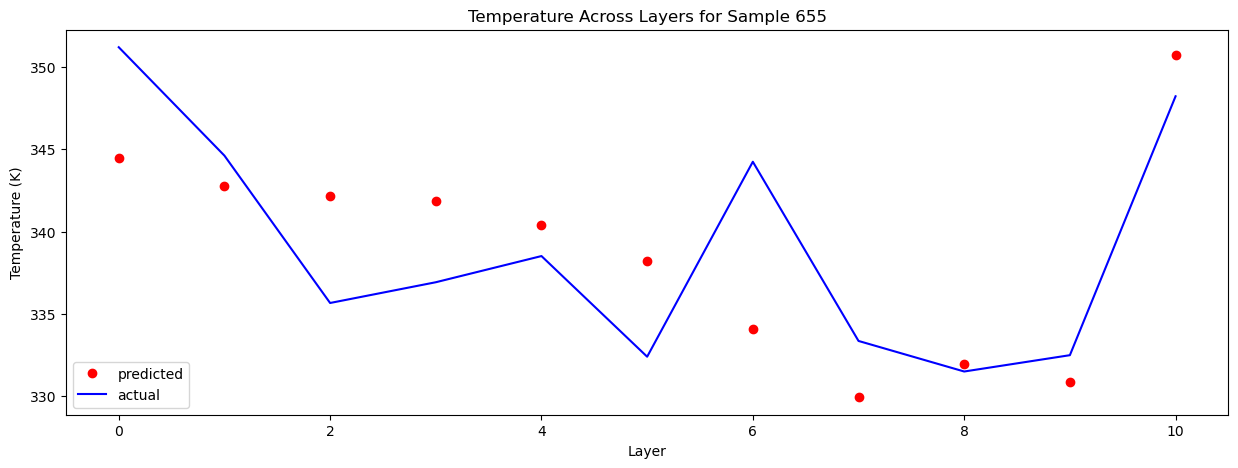

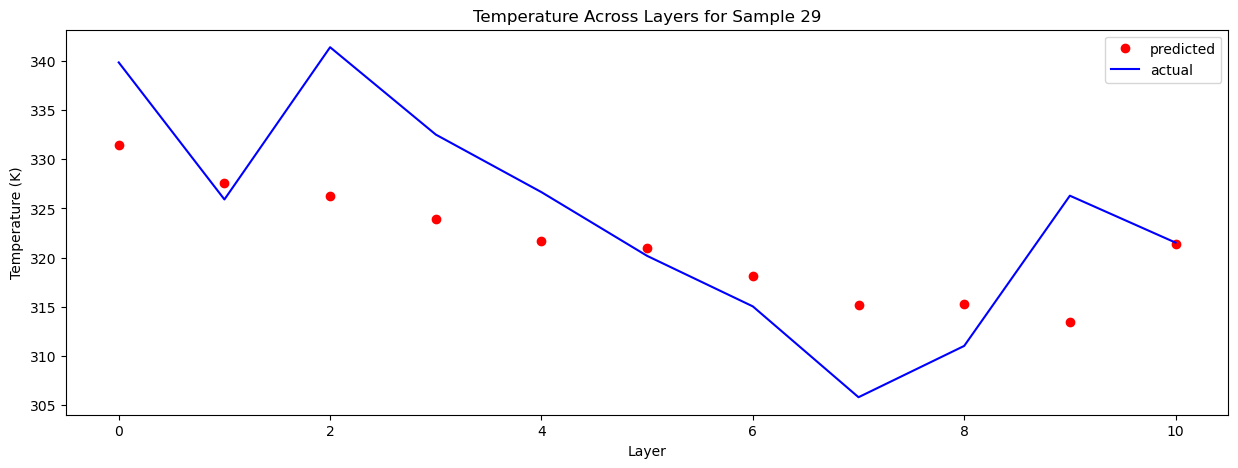

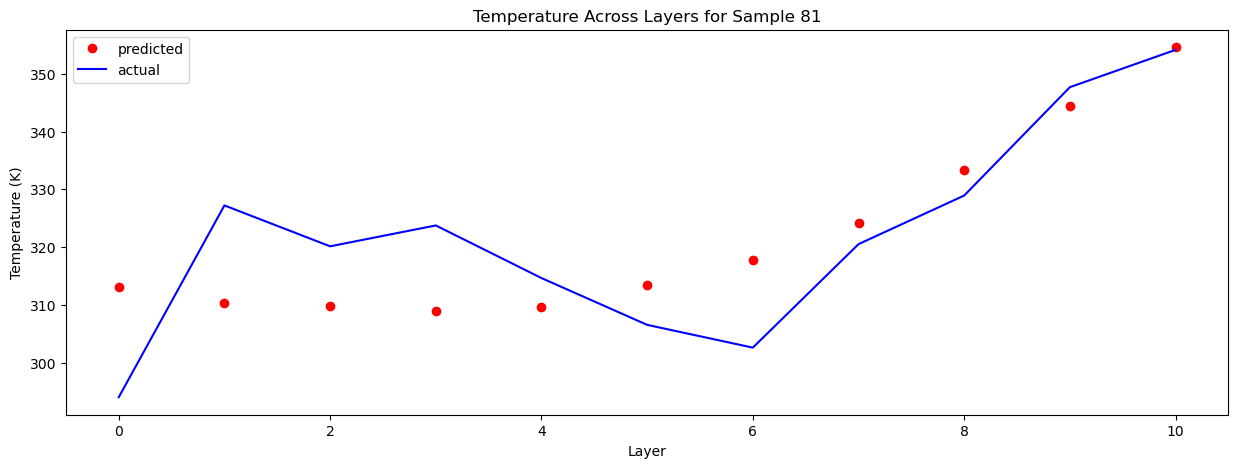

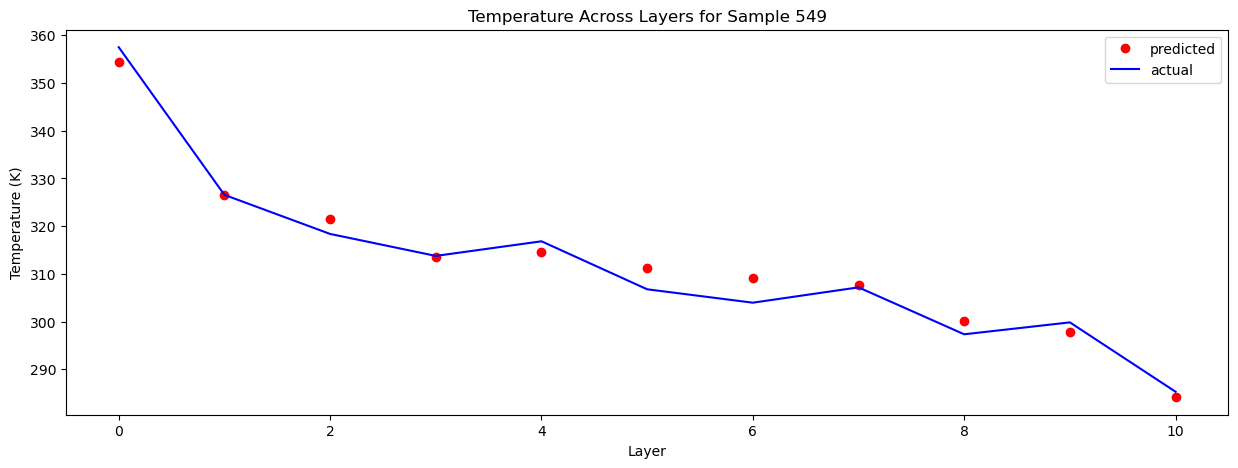

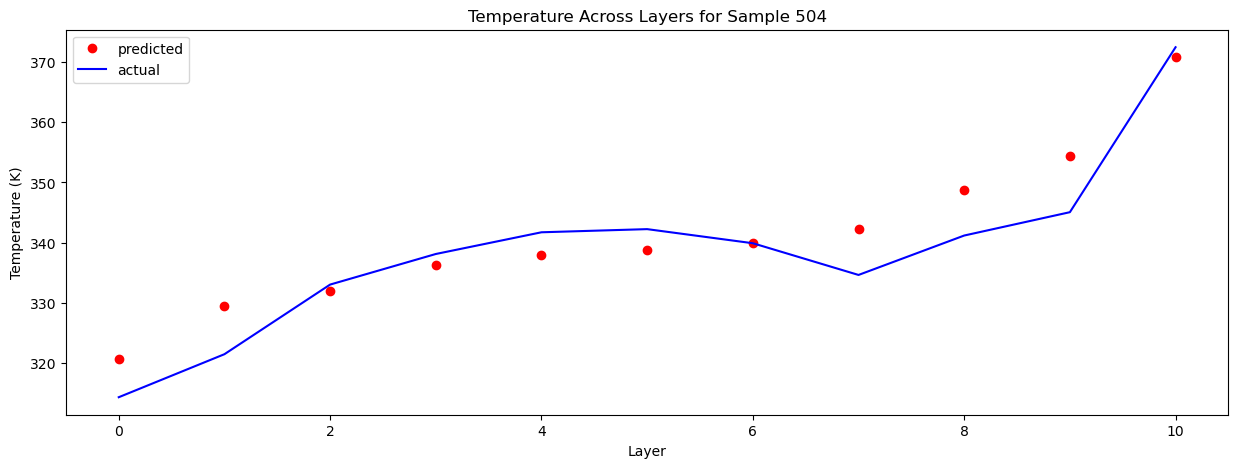

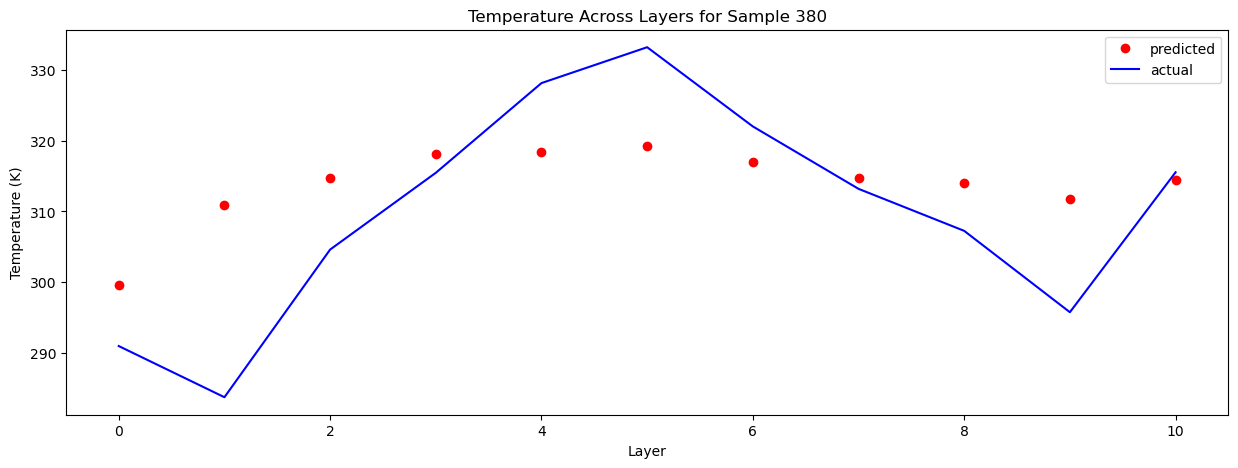

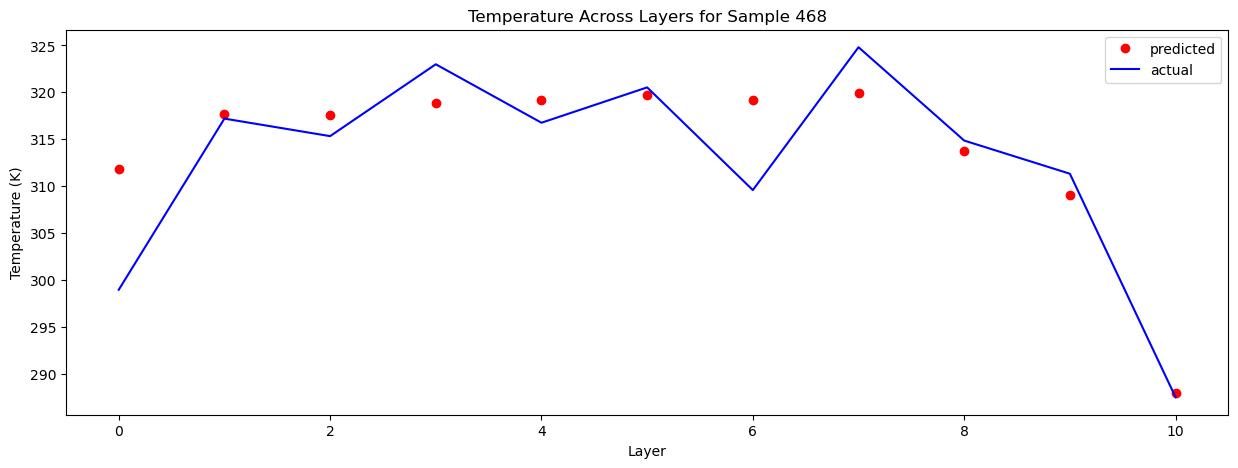

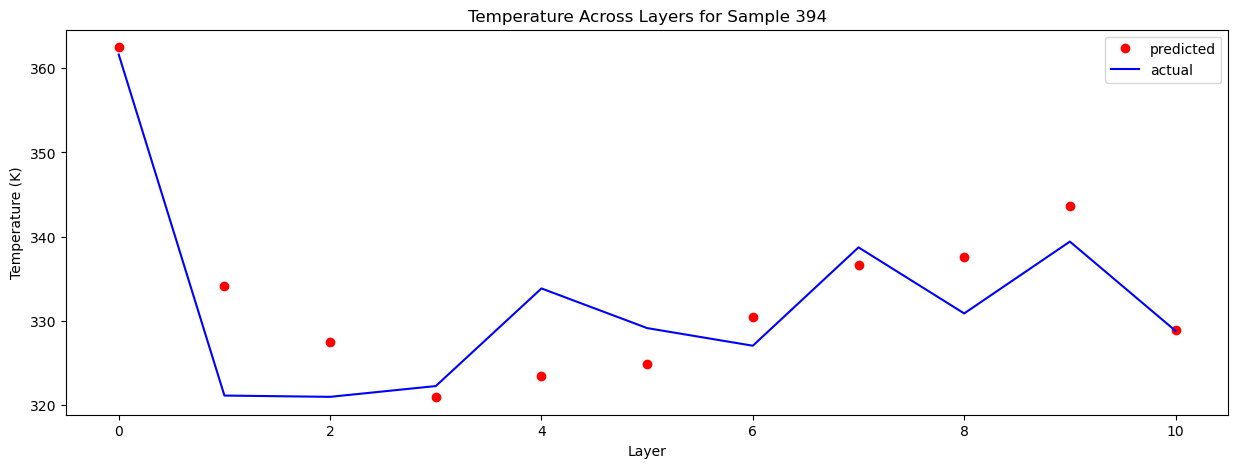

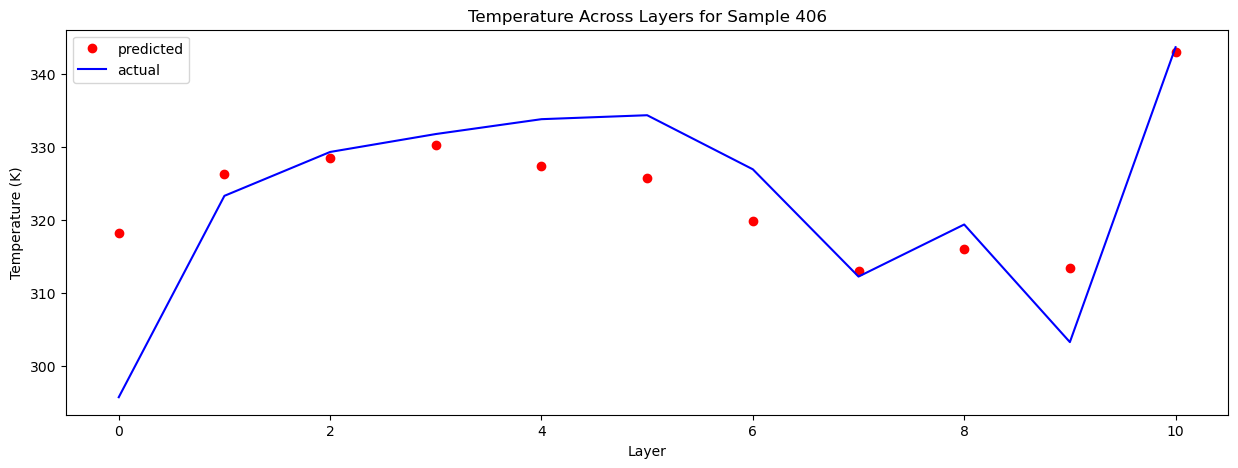

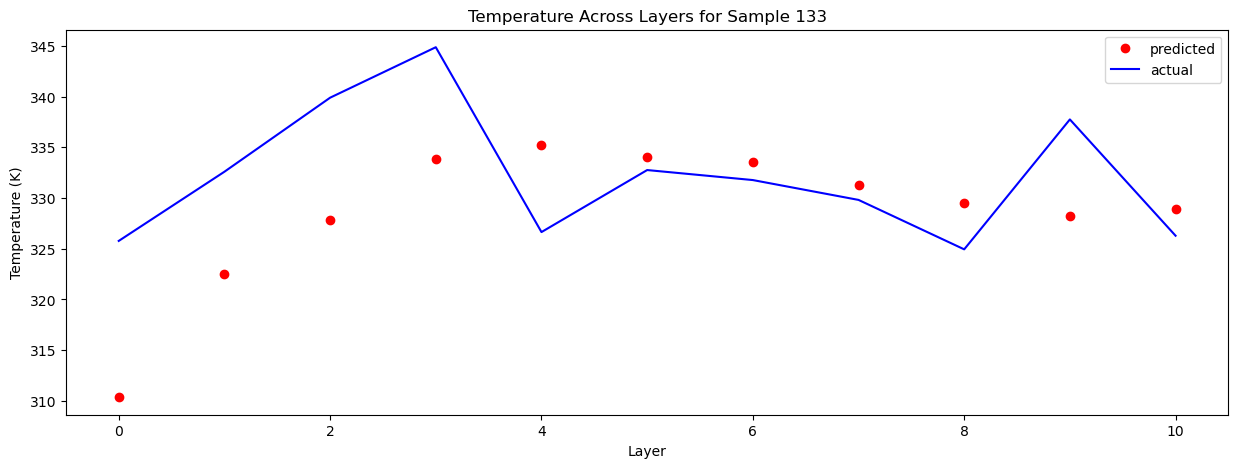

In [862]:
# plot spectrum --> temperature error
import random
num_graphs = 10
indices = []

with torch.no_grad():
    for i in range(0, num_graphs):
        n = random.randint(0, len(pred_temp))
        indices.append(n)

    for index in indices:
        plot_test_results(pred_temp[index], temp_test[index], index)
